In [5]:
import numpy as np
import pandas
import torch
import neuralnetworks_torch as nntorch
import os
import time
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import scipy
from scipy.spatial.distance import cosine as cos_dist

In [6]:
class CNN1D(torch.nn.Module):

    def __init__(self, n_inputs, n_channels, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):

        super().__init__()

        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers
            or len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')

        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu

        self.make_conv_and_fc_layers(n_inputs, n_channels, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                     patch_size_per_conv_layer, stride_per_conv_layer)
        
        self.Xmeans = None
        self.to(self.device)

    def make_conv_and_fc_layers(self, n_inputs, n_channels, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer,
                                n_outputs, patch_size_per_conv_layer, stride_per_conv_layer):
        # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = n_channels
        input_hw = n_inputs  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv1d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            print(input_hw,patch_size,stride,conv_layer_output_hw)
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

    def forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append(self.activation_function(conv_layer(Ys[-1])))

        flattened_input = Ys[-1].reshape(n_samples, -1)

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append(self.activation_function(fc_layer(flattened_input)))
            else:
                Ys.append(self.activation_function(fc_layer(Ys[-1])))

        if len(self.fc_layers) == 1:
            # only the output layer
            Ys.append(self.fc_layers[-1](flattened_input))
        else:
            Ys.append(self.fc_layers[-1](Ys[-1]))

        return Ys

    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]

    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):
        '''X and T must be numpy arrays'''

        self.classes = np.unique(T)
        T = np.arange(len(self.classes))[np.where(T.reshape(-1, 1) == self.classes)[1]]

        # Set data matrices to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing

        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        
        X.requires_grad_(True)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []

        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0

            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]

                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append(loss_sum / num_batches)

            if verbose and (epoch + 1) % (max(1, n_epochs // 10)) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self

    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1, 1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X):
        # Set input matrix to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        # Calculate output of net for all samples in X
        Y = self.forward(X)
        # Convert output to class probabilities
        probs = self.softmax(Y)
        # For each sample pick highest probability and translate that to class labels
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()].reshape(-1, 1)
        return classes, probs.detach().cpu().numpy()

In [7]:
def pad(data):
    eps = np.unique(data[:,0])
    samples = data
    padded = samples.copy()
    for i in eps:
        count = np.count_nonzero(samples[:,0] == i)
        if count < 10:
            max_idx = np.max(np.where(padded[:,0] == i)[0])
            #print(i,10-count,max_idx)
            for j in range(10-count):
                #print("Inserting %s at %s" % (padded[max_idx][0], max_idx+1+j))
                padded = np.insert(padded,max_idx+1+j,padded[max_idx],axis=0)
                #print(j,padded.shape)
                
    return padded

In [8]:
def make_train_test_data(classes, crop_len, feature_idxs):
    subset = crop_len

    Xtrain = np.vstack([train_data[c][:subset] for c in classes])[:,feature_idxs]
    Ttrain = np.vstack([train_data[c][:subset] for c in classes])[:,1]
    Xtrain = Xtrain.reshape(Xtrain.shape[0],-1)

    Xtest = np.vstack([test_data[c] for c in classes])[:,feature_idxs]
    Ttest = np.vstack([test_data[c] for c in classes])[:,1]

    n_channels = Xtrain.shape[1]
    print(Xtrain.shape,Ttrain.shape,Xtest.shape,Ttest.shape)

    Xtrain = Xtrain.flatten().reshape(-1,int(Xtrain.shape[1]*10)) # group into 10s
    Ttrain = np.max(Ttrain.flatten().reshape(-1,10), axis=1)

    Xtest = Xtest.flatten().reshape(-1,int(Xtest.shape[1]*10))
    Ttest = np.max(Ttest.flatten().reshape(-1,10), axis=1)
    print(Xtrain.shape,Ttrain.shape,Xtest.shape,Ttest.shape)

    Xtrain = Xtrain.reshape(-1,1,n_channels*10)
    Xtest = Xtest.reshape(-1,1,n_channels*10)

    print(Xtrain.shape,Ttrain.shape,Xtest.shape,Ttest.shape)

    return Xtrain,Ttrain,Xtest,Ttest

In [9]:
def train_classifier(X, T, n_classes, pretrained=None):
    gpu = True
    device = 'cpu'
    if gpu:
        if not torch.cuda.is_available():
            print("CUDA not available. Defaulting to CPU.")
        else:
            device = 'cuda:0'

    n_channels = X.shape[-1]//10
    
    cnn1d = CNN1D(n_channels*10, 1, [256, 128], [64, 64], n_classes, [n_channels, 4], [8, 2], device=device)
    
    #print(cnn1d.fc_layers[0].weight)
    
    if pretrained is not None:
        with torch.no_grad():
            for i in range(len(pretrained[0])):
                #print("Replacing %s with %s" % (cnn1d.conv_layers[i].weight,\
                #                                torch.nn.Parameter(pretrained[0][i])))
                cnn1d.conv_layers[i].weight = torch.nn.Parameter(pretrained[0][i])
            for i in range(len(pretrained[1])):
                #print("Replacing %s with %s" % (cnn1d.fc_layers[i].weight,\
                #                                torch.nn.Parameter(pretrained[1][i])))
                cnn1d.fc_layers[i].weight = torch.nn.Parameter(pretrained[1][i])

    n_epochs = 500
    batch_size = 100
    learning_rate = 0.001

    cnn1d.train(X, T, batch_size, n_epochs, learning_rate, method='adam')
    
    #print(cnn1d.fc_layers[0].weight)
    
    return cnn1d

In [10]:
# try some new data
# (load all samples from padded_data because we don't care about a balanced set for testing on new object types)
# 2 = cylinders (3 = capsules; 4 = small cubes)
def compare_classes(model, n_channels, novelty_threshold=25):
    novelty = []
    dissimilarities = []
    for i in range(5):
        new_data_class = i
        Xnew = np.vstack([padded_data[new_data_class]])[:,feature_idxs]
        Xnew = Xnew.flatten().reshape(-1,int(Xnew.shape[1]*10))
        Xnew = Xnew.reshape(-1,1,n_channels*10)

        print("New class:", new_data_class)

        # get most similar class
        classes, _ = model.use(Xnew)
        most_similar_class = int(scipy.stats.mode(classes).mode.item())
        print("Most similar class:", most_similar_class)

        # get embedding vectors of the new samples
        newYs = model.forward_all_outputs(torch.from_numpy(Xnew).float())
        new_logits = newYs[-2].detach().numpy()

        #print(np.var(new_logits, axis=0))
        #print(np.var(new_logits, axis=0).shape)
        #print("New data vector variance:", np.sum(np.var(new_logits, axis=0)))

        # get embedding vectors of the known class samples
        Xsim = np.vstack([padded_data[most_similar_class]])[:,feature_idxs]
        Xsim = Xsim.flatten().reshape(-1,int(Xsim.shape[1]*10))
        Xsim = Xsim.reshape(-1,1,n_channels*10)

        simYs = model.forward_all_outputs(torch.from_numpy(Xsim).float())
        sim_logits = simYs[-2].detach().numpy()

        #print(np.mean(new_logits, axis=0))
        #print(np.mean(sim_logits, axis=0))
        new_mean = np.mean(new_logits, axis=0)
        sim_mean = np.mean(sim_logits, axis=0)
        #print(new_mean-sim_mean)

        new_std = np.std(new_logits, axis=0)
        sim_std = np.std(sim_logits, axis=0)
        #print(sim_variance)

        print("Angle from sim_mean to sim_mean+std:",cos_dist(sim_mean,sim_mean+sim_std))
        #print("Angle from sim_mean to sim_mean-var:",cos_dist(sim_mean,sim_mean-sim_variance))
        print("Angle from sim_mean to new_mean:", cos_dist(sim_mean,new_mean))
        #print("Angle from new_mean to new_mean+std:", cos_dist(new_mean,new_mean+new_std))
        #print("Angle from sim_mean to new_mean+std:", cos_dist(sim_mean,new_mean+new_std))
        #print("Angle from sim_mean to new_mean-std:", cos_dist(sim_mean,new_mean-new_std))
        #min_diff_angle = np.min([cos_dist(sim_mean,new_mean+new_std),cos_dist(sim_mean,new_mean-new_std)])
        #max_diff_angle = np.max([cos_dist(sim_mean,new_mean+new_std),cos_dist(sim_mean,new_mean-new_std)])
        #print("Max angle from sim_mean to new_mean+/-std", max_diff_angle)
        #print("Max angle/angle from sim_mean to sim_mean+std:", max_diff_angle/cos_dist(sim_mean,sim_mean+sim_std))
        print("Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std:",\
              cos_dist(sim_mean,new_mean)/cos_dist(sim_mean,sim_mean+sim_std))
        likely_novel_class = cos_dist(sim_mean,new_mean)/cos_dist(sim_mean,sim_mean+sim_std) > 0
        #print(likely_novel_class)

        outlier_threshold = 1
        z_threshold = 3
        
        new_outliers = []
        for i in range(len(new_logits)):
            if cos_dist(sim_mean,new_logits[i])/cos_dist(sim_mean,sim_mean+sim_std) > outlier_threshold:
                #print(i,cos_dist(sim_mean,new_logits[i])/cos_dist(sim_mean,sim_mean+sim_std))
                new_outliers.append(cos_dist(sim_mean,new_logits[i])/cos_dist(sim_mean,sim_mean+sim_std))
        #print(len(new_outliers))
        #print(np.mean([new_outliers]),np.std([new_outliers]))
        new_outliers_pruned = []
        for i in range(len(new_outliers)):
            if (new_outliers[i]-np.mean([new_outliers]))/np.std([new_outliers]) < z_threshold:
                #print(new_outliers[i])
                new_outliers_pruned.append(new_outliers[i])
        #print(len(new_outliers_pruned))
        #print()
        
        sim_outliers = []
        for i in range(len(sim_logits)):
            if cos_dist(sim_mean,sim_logits[i])/cos_dist(sim_mean,sim_mean+sim_std) > outlier_threshold:
                #print(i,cos_dist(sim_mean,sim_logits[i])/cos_dist(sim_mean,sim_mean+sim_std))
                sim_outliers.append(cos_dist(sim_mean,sim_logits[i])/cos_dist(sim_mean,sim_mean+sim_std))
        #print(len(sim_outliers))
        #print(np.mean([sim_outliers]),np.std([sim_outliers]))
        sim_outliers_pruned = []
        for i in range(len(sim_outliers)):
            if (sim_outliers[i]-np.mean([sim_outliers]))/np.std([sim_outliers]) < z_threshold:
                #print(sim_outliers[i])
                sim_outliers_pruned.append(sim_outliers[i])
        #print(len(sim_outliers_pruned))
                
        #print(np.sum(new_outliers_pruned),np.sum(sim_outliers_pruned))
        outlier_ratio = np.sum(new_outliers_pruned)/np.sum(sim_outliers_pruned) \
              if np.sum(sim_outliers_pruned) > 0 else float('inf')
        print("Outlier ratio:",outlier_ratio)
        likely_novel_class = (outlier_ratio == float('inf')) if likely_novel_class else likely_novel_class
        
        dissimilarity = outlier_ratio*cos_dist(sim_mean,new_mean)/cos_dist(sim_mean,sim_mean+sim_std)*\
        np.sum(sim_outliers_pruned)
        print("Dissimilarity from most similar class:", dissimilarity)

        likely_novel_class = (dissimilarity > novelty_threshold) if not likely_novel_class else likely_novel_class
        print("Likely novel class:",likely_novel_class)
        
        print()
        
        dissimilarities.append(dissimilarity)
        novelty.append(likely_novel_class)
        
    return novelty,dissimilarities

Column key:
* Column 1 is the episode number.
* Column 2 is the theme object;  0 = big cube, 1 = sphere, 2 = cylinder, 3 = capsule, 4 = small cube.
* Column 3 is the destination object.  Always 0 because we were always stacking on a cube.
* Columns 4-6 are the rotation (4 = X; 5 = Y; 6 = Z) of the theme object at the start of the trial, in radians.
* Column 7 is the angle, theta (in radians), between the vertical upright axis in world space (0,1,0), and the normalized intrinsic upward axis of the theme object at the start of the trial.
* Columns 8, 9 are the 2-dimensions of the action that was executed.
* Columns 10-12 are the rotation of the theme object after the action was completed (same convention as 4-6), in radians.
* Column 13 is the theta angle, as in 7, but after action was completed.
* Column 14-16 is the "jitter" force applied to the object after placement (to simulate release)
* Columns 17-19 is the center of the theme object (after action completion)
* Columns 20-22 is the size of the theme object
* Column 23-25 is the observation after action completion. Here I’m using height and center of gravity so it takes up 3 columns
* Column 26 is the reward. With this model, the agent gets -1 for missing the destination object entirely, 9 for touching the destination object but the theme falls off, and up to 1000 for successful stacking (1000 on the first try, -100 for each additional attempt).
* Column 27 is the cumulative reward over the episode.
* Column 28 is the mean reward over the episode.

In [11]:
# load up data
data = {}
data[0] = pandas.read_csv('trial-data/122921-2cubes.csv', header=None)
data[0] = data[0][data[0].iloc[:,1] == 0]

data[1] = pandas.read_csv('trial-data/122921-cube_sphere.csv', header=None)
data[1] = data[1][data[1].iloc[:,1] == 1]

data[2] = pandas.read_csv('trial-data/122921-cube_cylinder.csv', header=None)
data[2] = data[2][data[2].iloc[:,1] == 2]

data[3] = pandas.read_csv('trial-data/122921-cube_capsule.csv', header=None)
data[3] = data[3][data[3].iloc[:,1] == 3]

data[4] = pandas.read_csv('trial-data/122921-bigcube_smallcube.csv', header=None)
data[4] = data[4][data[4].iloc[:,1] == 4]

In [12]:
# pad data
padded_data = {}
padded_data[0] = pad(data[0].to_numpy())
padded_data[1] = pad(data[1].to_numpy())
padded_data[2] = pad(data[2].to_numpy())
padded_data[3] = pad(data[3].to_numpy())
padded_data[4] = pad(data[4].to_numpy())

test_n = 100 # 100 test samples of each class

# split train and test
test_data = {}
test_data[0] = padded_data[0][-test_n:]
test_data[1] = padded_data[1][-test_n:]
test_data[2] = padded_data[2][-test_n:]
test_data[3] = padded_data[3][-test_n:]
test_data[4] = padded_data[4][-test_n:]

crop_len = min([len(padded_data[k]) for k in padded_data])-test_n

print(crop_len)

train_data = {}
train_data[0] = padded_data[0][:crop_len]
train_data[1] = padded_data[1][:crop_len]
train_data[2] = padded_data[2][:crop_len]
train_data[3] = padded_data[3][:crop_len]
train_data[4] = padded_data[4][:crop_len]

for k in train_data:
    print(train_data[k].shape,train_data[k])

900
(900, 28) [[   3.    0.    0. ... 1000. 1000. 1000.]
 [   3.    0.    0. ... 1000. 1000. 1000.]
 [   3.    0.    0. ... 1000. 1000. 1000.]
 ...
 [  92.    0.    0. ... 1000. 1000. 1000.]
 [  92.    0.    0. ... 1000. 1000. 1000.]
 [  92.    0.    0. ... 1000. 1000. 1000.]]
(900, 28) [[ 3.        1.        0.       ...  9.        9.        9.      ]
 [ 3.        1.        0.       ...  9.       18.        9.      ]
 [ 3.        1.        0.       ... -1.       17.        5.666667]
 ...
 [92.        1.        0.       ...  9.       62.        7.75    ]
 [92.        1.        0.       ... -1.       61.        6.777778]
 [92.        1.        0.       ... -1.       60.        6.      ]]
(900, 28) [[   3.    2.    0. ... 1000. 1000. 1000.]
 [   3.    2.    0. ... 1000. 1000. 1000.]
 [   3.    2.    0. ... 1000. 1000. 1000.]
 ...
 [  92.    2.    0. ...  800.  798.  266.]
 [  92.    2.    0. ...  800.  798.  266.]
 [  92.    2.    0. ...  800.  798.  266.]]
(900, 28) [[ 3.        3.     

# A: Given cube and sphere

Test for the ability to infer the existence of cylinder and capsule as distinct classes while not splitting small cube from big cube.

========== Experiment 1 ==========
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0022259950637817383
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0032982826232910156
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: inf
Dissimi

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.0022259950637817383
Angle from sim_mean to new_mean: 8.404254913330078e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.003775504739463396
Outlier ratio: 16.481377757110497
Dissimilarity from most similar class: 56.46960093349414
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0032982826232910156
Angle from sim_mean to new_mean: 0.008459627628326416
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.56485832008096
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0022259950637817383
Angle from sim_mean to new_mean: 1.7881393432617188e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 8.032988807368929e-05
Outlier ratio: 4.8429705005331725
Dissimilarity from most similar class: 0.35304915041682705
Likely novel class: False

========== Experiment 2 ==========
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.002156674861907959
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from si

Angle from sim_mean to sim_mean+std: 0.0010260343551635742
Angle from sim_mean to new_mean: 7.152557373046875e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0006971070059254096
Outlier ratio: 3.80702459948744
Dissimilarity from most similar class: 3.746840006328796
Likely novel class: False

========== Experiment 6 ==========
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0004897713661193848
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.

Angle from sim_mean to sim_mean+std: 0.0015363097190856934
Angle from sim_mean to new_mean: 5.960464477539062e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0003879728419010669
Outlier ratio: 4.521886968517359
Dissimilarity from most similar class: 2.1463032754729476
Likely novel class: False

========== Experiment 10 ==========
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0007326602935791016
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std:

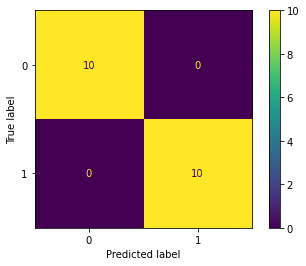

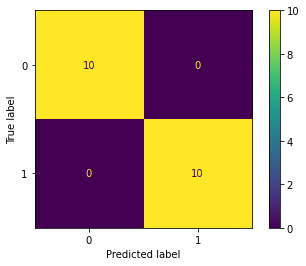

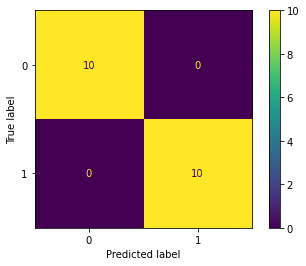

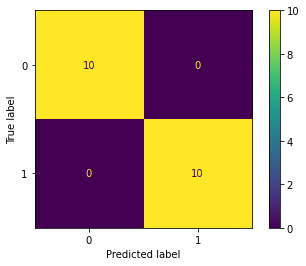

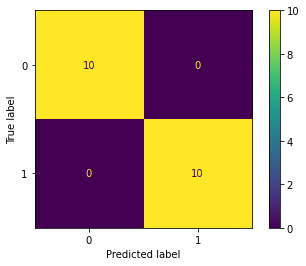

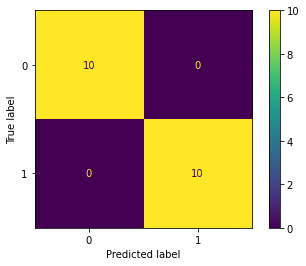

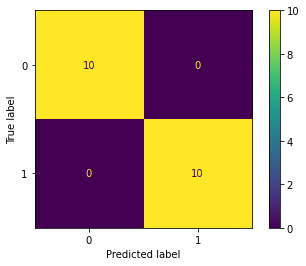

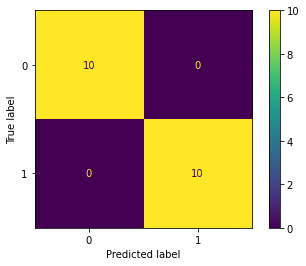

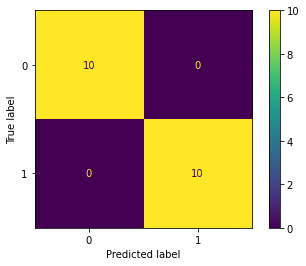

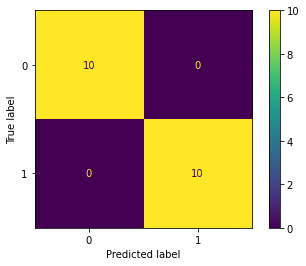

In [23]:
ground_truth = [False, False, True, True, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    
    feature_idxs = [*range(3,16),*range(22,28)] 
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 2)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(2,len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# B: Given cube, sphere, and cylinder

Test for the ability to infer the existence of capsule as a distinct class while not splitting small cube from big cube.

========== Experiment 1 ==========
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.061
adam: Epoch 100 Loss 0.021
adam: Epoch 150 Loss 0.004
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0021753907203674316
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0019460320472717285
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimi

adam: Epoch 50 Loss 0.055
adam: Epoch 100 Loss 0.020
adam: Epoch 150 Loss 0.005
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.016221702098846436
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.012523651123046875
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.027739882469177246
Angle from sim_mean to new_mean: 0.0
Angle from sim_m

adam: Epoch 50 Loss 0.058
adam: Epoch 100 Loss 0.019
adam: Epoch 150 Loss 0.006
adam: Epoch 200 Loss 0.003
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0017638206481933594
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0015887618064880371
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.020022988319396973
Angle from sim_mean to new_mean: 0.0
Angle from sim

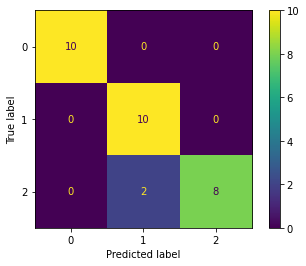

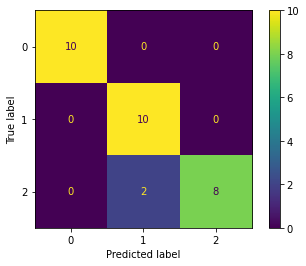

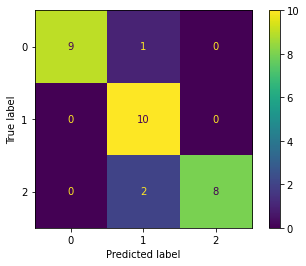

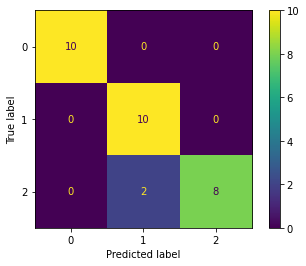

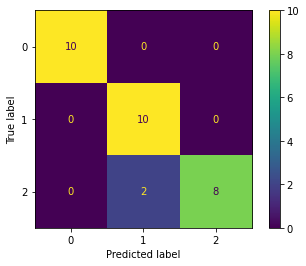

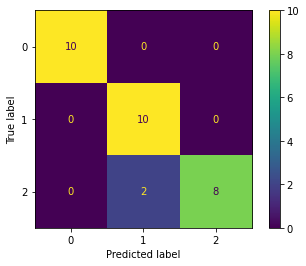

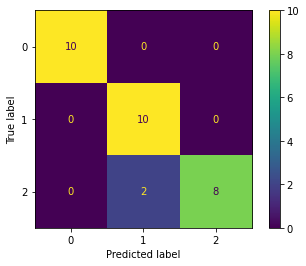

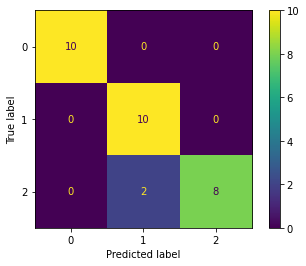

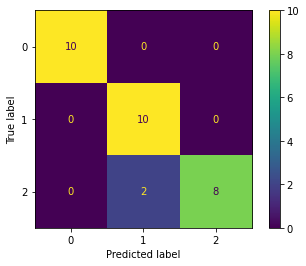

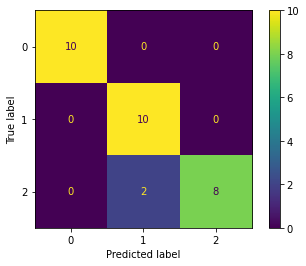

In [24]:
ground_truth = [False, False, False, True, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))

    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1,2], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 3)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(2,len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# C: Given cube, sphere, and capsule

Test for the ability to infer the existence of cylinder as a distinct class while not splitting small cube from big cube.

========== Experiment 1 ==========
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.005
adam: Epoch 100 Loss 0.002
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.019071459770202637
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 7.808208465576172e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimil

adam: Epoch 50 Loss 0.006
adam: Epoch 100 Loss 0.002
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.018473148345947266
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.2576580047607422e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.018473148345947266
Angle from sim_mean to new_mean: 0.0003628134727478

adam: Epoch 50 Loss 0.007
adam: Epoch 100 Loss 0.002
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01813197135925293
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.9848346710205078e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01813197135925293
Angle from sim_mean to new_mean: 0.000512540340423584

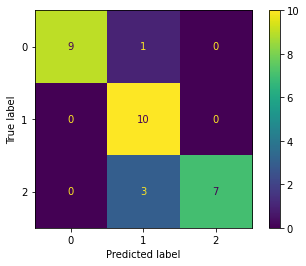

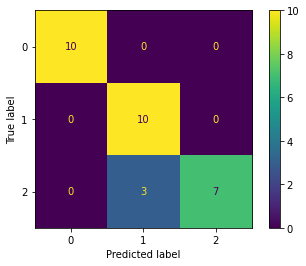

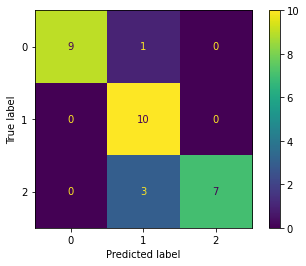

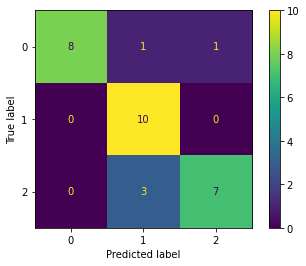

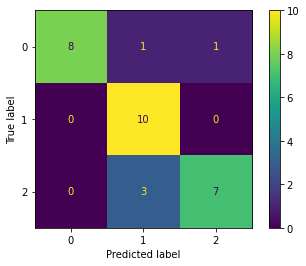

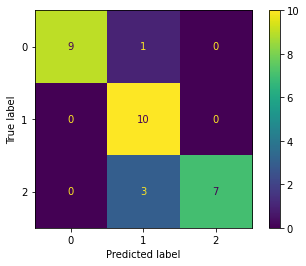

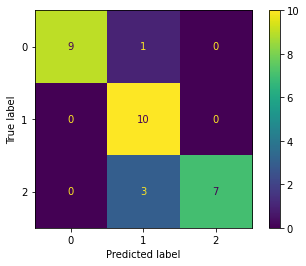

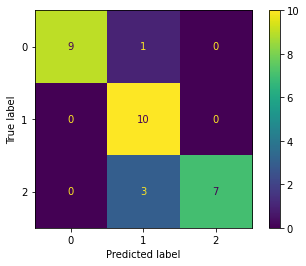

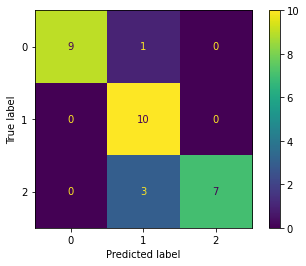

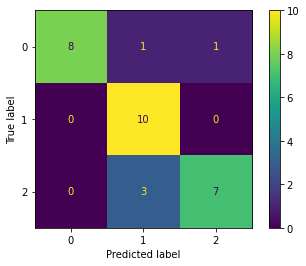

In [25]:
ground_truth = [False, False, True, False, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1,3], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 3)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(2,len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# D: Given cube, sphere, cylinder, and capsule

Test that small cube is not considered to be different from big cube.

========== Experiment 1 ==========
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.033
adam: Epoch 100 Loss 0.008
adam: Epoch 150 Loss 0.004
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.001

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01034998893737793
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.00040477514266967773
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimil

adam: Epoch 50 Loss 0.027
adam: Epoch 100 Loss 0.007
adam: Epoch 150 Loss 0.004
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.016749143600463867
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0014654994010925293
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.05371016263961792
Angle from sim_mean to new_mean: 0.0
Angle from sim_m

adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.011562764644622803
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.00038826465606689453
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.043416380882263184
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+

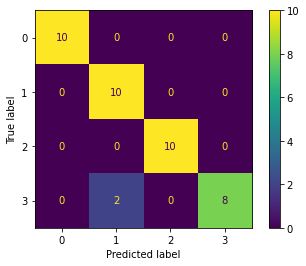

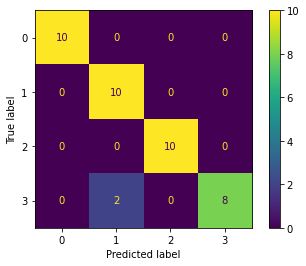

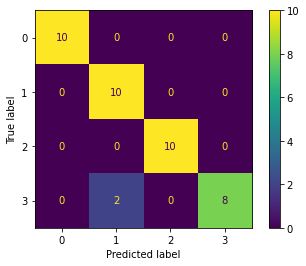

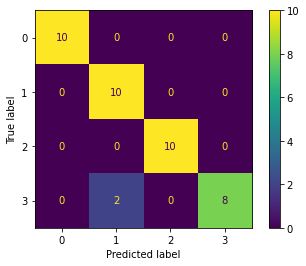

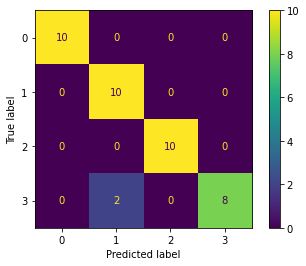

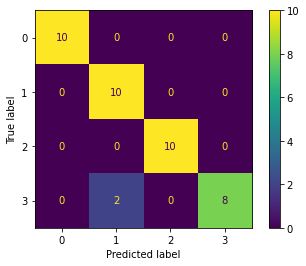

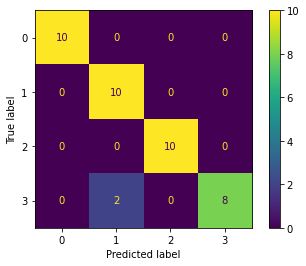

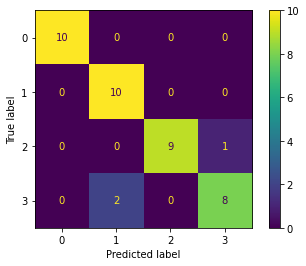

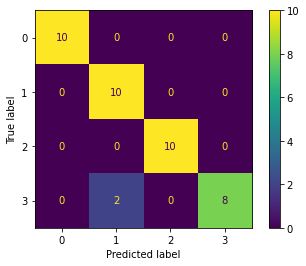

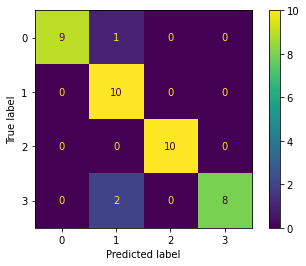

In [26]:
ground_truth = [False, False, False, False, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1,2,3], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 4)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(2,len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# E: Given cube and sphere (no VoxML features)

Like (A), but the training data drops the VoxML-derived "jitter" features.

========== Experiment 1 ==========
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.006064713001251221
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 4.231929779052734e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimila

Outlier ratio: 4.735854213538281
Dissimilarity from most similar class: 0.0
Likely novel class: False

========== Experiment 5 ==========
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.007197439670562744
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 4.172325134277344e-07
Angle from sim_mean to new_mean: 0.

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 4.807694594519627
Dissimilarity from most similar class: 0.7301720570318834
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 2.7298927307128906e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 458.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.013111591339111328
Angle from sim_mean to new_mean: 4.172325134277344e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 3.182165327126596e-05


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 1.9968452674842274
Dissimilarity from most similar class: 0.04824786654297361
Likely novel class: False

========== Experiment 8 ==========
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.013951480388641357
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.1920928955078125e-07
Angle from sim_me

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 4.961833035365505
Dissimilarity from most similar class: 0.6345437321699606
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 3.9696693420410156e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 666.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.009387671947479248
Angle from sim_mean to new_mean: 1.7881393432617188e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00019047739985650702


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 1.9294161238382845
Dissimilarity from most similar class: 0.35249038565357477
Likely novel class: False

========== Experiment 10 ==========
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.014609277248382568
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Outlier ratio: 5.657708546562056
Dissimilarity from most similar class: 1.1685597697820658
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 3.93986701965332e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.014609277248382568
Angle from sim_mean to new_mean: 2.0265579223632812e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00013871719236402654
Outlier ratio: 2.1970451793398253
Dissimilarity from most similar class: 0.2084954320635687
Likely novel class: False

True [False False False False False False False False False False] 0.0
True [ True  True  True  True  True  True  True  True  True  True] 1.0
False [False False False False False False False False False False] 1.0
[0.0, 1.0, 1.0] 0.6666666666666666


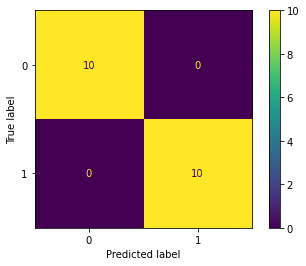

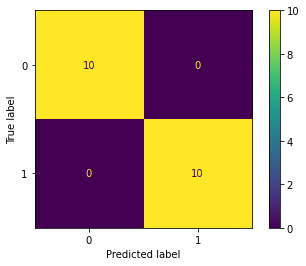

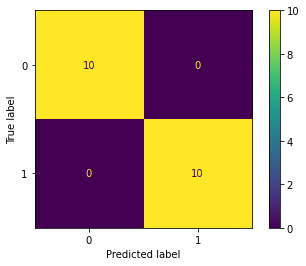

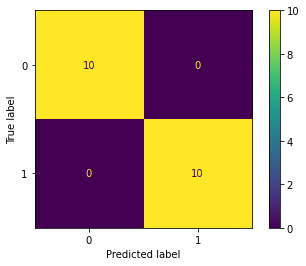

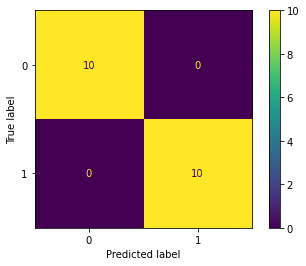

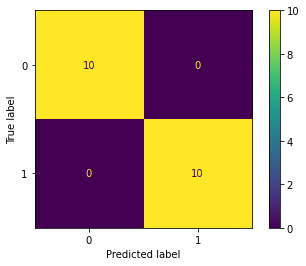

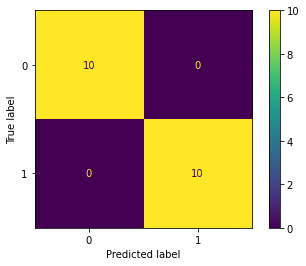

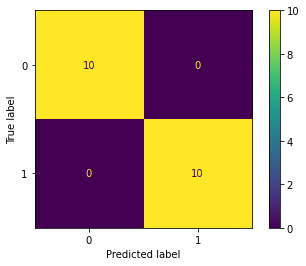

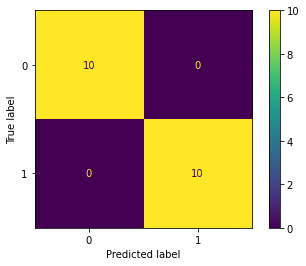

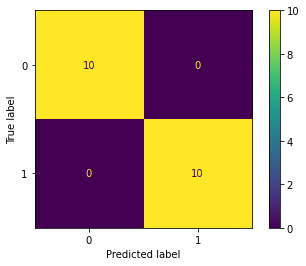

In [32]:
ground_truth = [False, False, True, True, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    
    #feature_idxs = [*range(3,16),*range(22,28)]
    feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 2)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(2,len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# F: Given cube, sphere, and cylinder (no VoxML features)

Like (B), but the training data drops the VoxML-derived "jitter" features.

========== Experiment 1 ==========
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.260
adam: Epoch 100 Loss 0.252
adam: Epoch 150 Loss 0.238
adam: Epoch 200 Loss 0.226
adam: Epoch 250 Loss 0.202
adam: Epoch 300 Loss 0.182
adam: Epoch 350 Loss 0.169
adam: Epoch 400 Loss 0.160
adam: Epoch 450 Loss 0.151
adam: Epoch 500 Loss 0.138

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.016366302967071533
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.000443875789642334
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilar

adam: Epoch 50 Loss 0.259
adam: Epoch 100 Loss 0.254
adam: Epoch 150 Loss 0.244
adam: Epoch 200 Loss 0.226
adam: Epoch 250 Loss 0.205
adam: Epoch 300 Loss 0.178
adam: Epoch 350 Loss 0.160
adam: Epoch 400 Loss 0.147
adam: Epoch 450 Loss 0.135
adam: Epoch 500 Loss 0.125

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0015129446983337402
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.017326653003692627
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0015129446983337402
Angle from sim_mean to new_mean: 0.0001101493835449

adam: Epoch 50 Loss 0.262
adam: Epoch 100 Loss 0.256
adam: Epoch 150 Loss 0.250
adam: Epoch 200 Loss 0.239
adam: Epoch 250 Loss 0.216
adam: Epoch 300 Loss 0.200
adam: Epoch 350 Loss 0.186
adam: Epoch 400 Loss 0.168
adam: Epoch 450 Loss 0.160
adam: Epoch 500 Loss 0.152

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.005986630916595459
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 3.1888484954833984e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.005986630916595459
Angle from sim_mean to new_mean: 0.0002697110176086

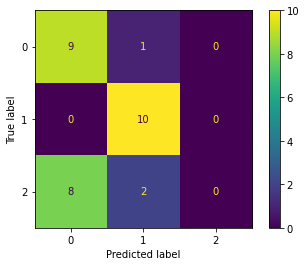

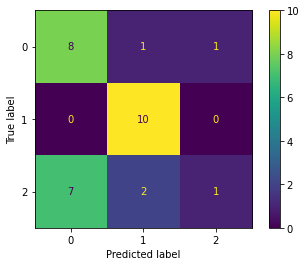

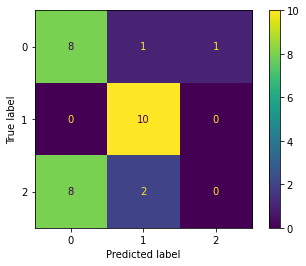

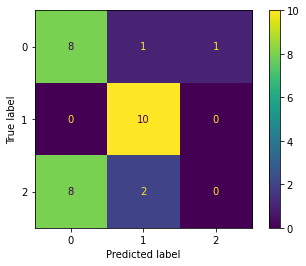

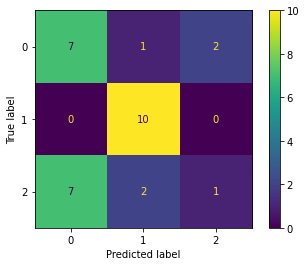

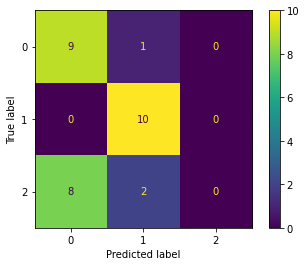

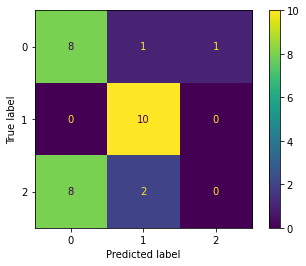

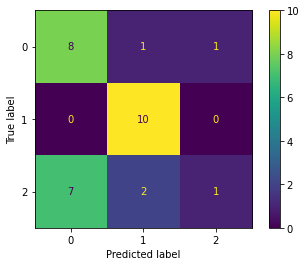

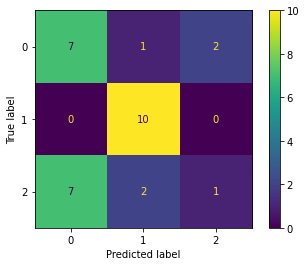

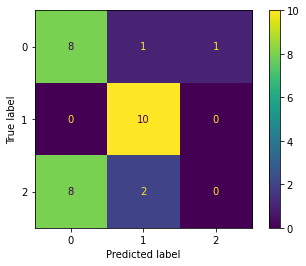

In [39]:
ground_truth = [False, False, False, True, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    
    #feature_idxs = [*range(3,16),*range(22,28)]
    feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1,2], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 3)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(2,len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# G: Given cube, sphere, and capsule (no VoxML features)

Like (C), but the training data drops the VoxML-derived "jitter" features.

========== Experiment 1 ==========
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.023
adam: Epoch 100 Loss 0.009
adam: Epoch 150 Loss 0.006
adam: Epoch 200 Loss 0.003
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.013603448867797852
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.8477439880371094e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimil

adam: Epoch 50 Loss 0.025
adam: Epoch 100 Loss 0.007
adam: Epoch 150 Loss 0.003
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01959371566772461
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.7881393432617188e-07
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01959371566772461
Angle from sim_mean to new_mean: 0.000384032726287841

adam: Epoch 50 Loss 0.025
adam: Epoch 100 Loss 0.011
adam: Epoch 150 Loss 0.008
adam: Epoch 200 Loss 0.005
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01797473430633545
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.00038939714431762695
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01797473430633545
Angle from sim_mean to new_mean: 0.000259935855865478

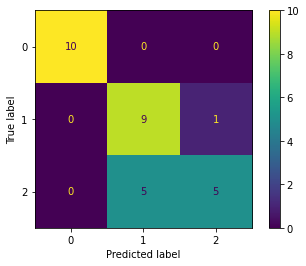

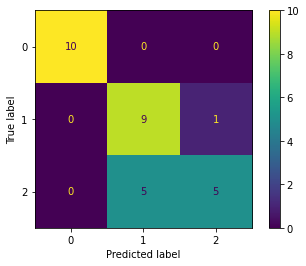

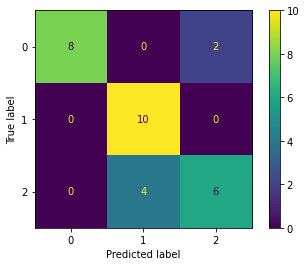

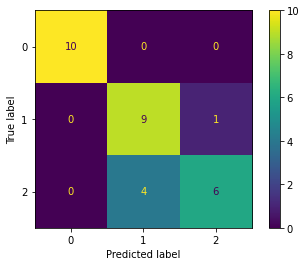

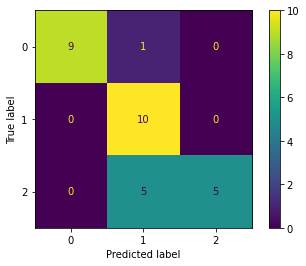

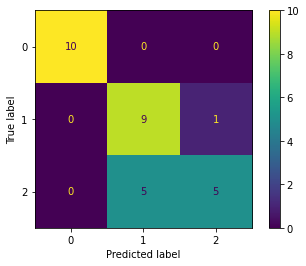

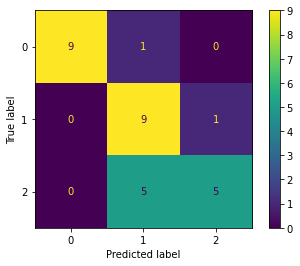

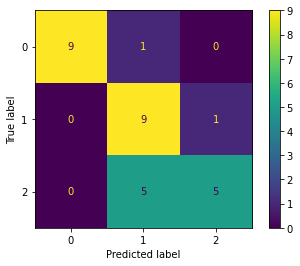

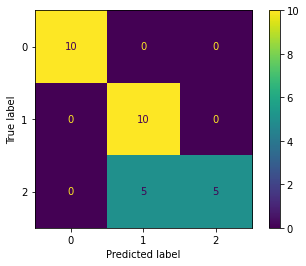

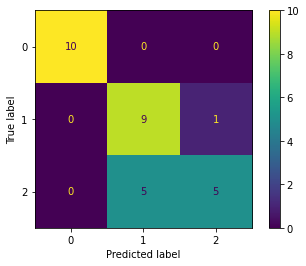

In [40]:
ground_truth = [False, False, True, False, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    
    #feature_idxs = [*range(3,16),*range(22,28)]
    feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1,3], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 3)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(2,len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# H: Given cube, sphere, cylinder, and capsule

Like (D), but the training data drops the VoxML-derived "jitter" features.

========== Experiment 1 ==========
(3600, 16) (3600,) (400, 16) (400,)
(360, 160) (360,) (40, 160) (40,)
(360, 1, 160) (360,) (40, 1, 160) (40,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.438
adam: Epoch 100 Loss 0.385
adam: Epoch 150 Loss 0.360
adam: Epoch 200 Loss 0.352
adam: Epoch 250 Loss 0.348
adam: Epoch 300 Loss 0.346
adam: Epoch 350 Loss 0.343
adam: Epoch 400 Loss 0.338
adam: Epoch 450 Loss 0.336
adam: Epoch 500 Loss 0.334

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.034202516078948975
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.1324882507324219e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimil

adam: Epoch 50 Loss 0.430
adam: Epoch 100 Loss 0.381
adam: Epoch 150 Loss 0.356
adam: Epoch 200 Loss 0.350
adam: Epoch 250 Loss 0.345
adam: Epoch 300 Loss 0.337
adam: Epoch 350 Loss 0.335
adam: Epoch 400 Loss 0.333
adam: Epoch 450 Loss 0.332
adam: Epoch 500 Loss 0.331

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.06374281644821167
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.7285346984863281e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.06374281644821167
Angle from sim_mean to new_mean: 0.001009702682495117

adam: Epoch 50 Loss 0.437
adam: Epoch 100 Loss 0.396
adam: Epoch 150 Loss 0.359
adam: Epoch 200 Loss 0.351
adam: Epoch 250 Loss 0.347
adam: Epoch 300 Loss 0.345
adam: Epoch 350 Loss 0.342
adam: Epoch 400 Loss 0.339
adam: Epoch 450 Loss 0.335
adam: Epoch 500 Loss 0.334

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.05779367685317993
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0002091526985168457
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.05779367685317993
Angle from sim_mean to new_mean: 0.0006892681121826172

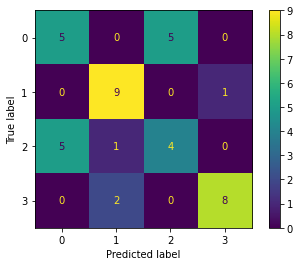

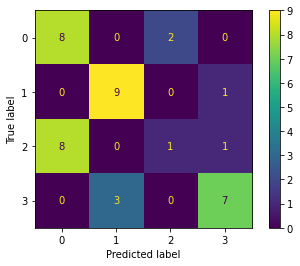

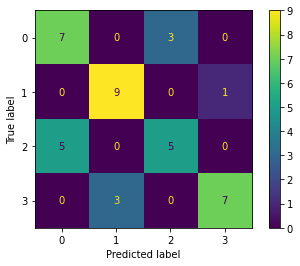

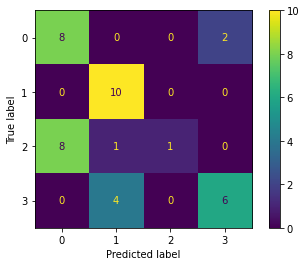

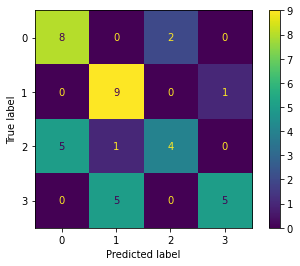

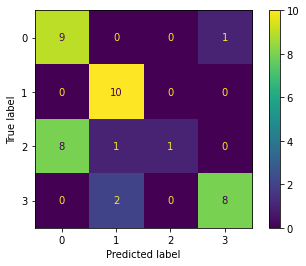

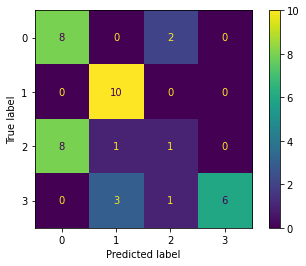

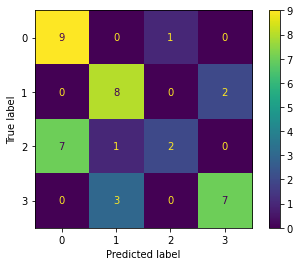

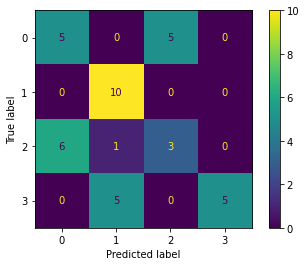

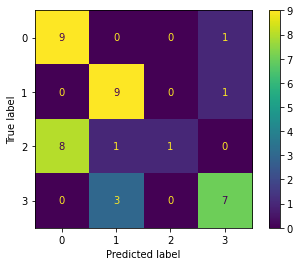

In [13]:
ground_truth = [False, False, False, False, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    
    #feature_idxs = [*range(3,16),*range(22,28)]
    feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1,2,3], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 4)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(2,len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))